![](https://mcd.unison.mx/wp-content/themes/awaken/img/logo_mcd.png)

# Ejemplo de regularización con regresión logística

## Aprendizaje Automático Aplicado

## Maestría en Ciencia de Datos

**Julio Waissman**, 2025

[Abrir en google Colab](https://drive.google.com/file/d/1MBXeAmU7EfMJtigozlmy4hG-7gkpm_8V/view?usp=sharing)

In [9]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement


plt.rcParams['figure.figsize'] = (10,5)
plt.style.use('ggplot')

## 1. Algunas funciones útiles

Esto, antes de agregarle la regularización

In [10]:
def medias_std(x):
    """
    Obtiene un vector de medias y desviaciones estandar para normalizar

    """
    return np.mean(x, axis=0), np.std(x, axis=0)

def normaliza(x, mu, des_std):
    """
    Normaliza los datos x

    """
    return (x - mu) / des_std

def map_poly(grad, x):
    """
    Encuentra las características polinomiales hasta el grado grad de la matriz de datos x, asumiendo que x[:n, 0] es la expansión de orden 1 (los valores de cada atributo)

    """
    if int(grad) < 2:
        raise ValueError('grad debe de ser mayor a 1')

    M, n = x.shape
    atrib = x.copy()
    x_phi = x.copy()
    for i in range(2, int(grad) + 1):
        for comb in combinations_with_replacement(range(n), i):
            x_phi = np.c_[x_phi, np.prod(atrib[:, comb], axis=1)]
    return x_phi

def logistica(z):
    """
    Calcula la función logística para cada elemento de z

    """
    return 1 / (1 + np.exp(-z))

def error_in(x, y, w, b):
    """
    Calcula el error en muestra para la regresión logística

    """
    a = logistica(x @ w + b)
    return -np.nansum(
            np.sum(np.log(a[y > 0.5])) +
            np.sum(np.log(1 - a[y < 0.5]))
        ) / a.shape[0]

def gradiente_error(x, y, w, b):
    """
    Calcula el gradiente de la función de error en muestra.

    """
    M = x.shape[0]
    error = y - logistica(x @ w + b)
    dw = -x.T @ error / M
    db = - error.mean()
    return dw, db

def dg(x, y, w, b, alpha, max_iter=10_000, tol=1e-6, historial=False):
    """
    Descenso de gradiente por lotes

    """
    M, n = x.shape
    hist = [error_in(x, y, w, b)] if historial else None
    for epoch in range(1, max_iter):
        dw, db = gradiente_error(x, y, w, b)
        w -= alpha * dw
        b -= alpha * db
        error = error_in(x, y, w, b)
        if historial:
            hist.append(error)
        if np.abs(np.max(dw)) < tol:
            break
    return w, b, hist

def predictor(x, w, b):
    """
    Predice la clase de cada elemento de x

    """
    return np.where(x @ w + b > 0, 1, 0)


## 2. Regularización

Tomemos una base de datos que si bien es sintética es representativa de una familia de problemas a resolver. Supongamos que estámos opimizando la fase de pruebas dentro de la linea de producción de la empresa Microprocesadores del Noroeste S.A. de C.V.. La idea es reducir el banco de pruebas de cada nuevo microprocesador fabricado y en lugar de hacer 50 pruebas, reducirlas a 2. En el conjunto de datos tenemos los valores que obtuvo cada componente en las dos pruebas seleccionadas, y la decisión que se tomo con cada dispositivo (esta desición se tomo con el banco de 50 reglas). Los datos los podemos visualizar a continuación.

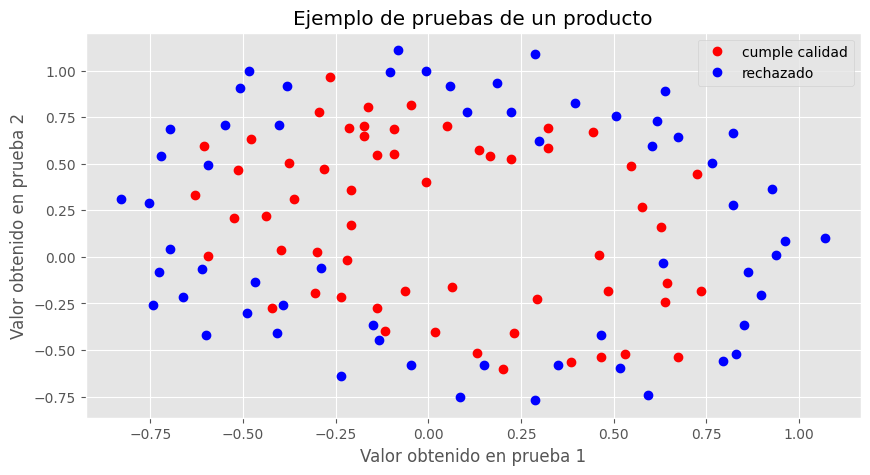

In [11]:
url = "https://github.com/mcd-unison/aaa-curso/raw/main/ejemplos/prod_test.csv"
datos = np.loadtxt(url, comments='%', delimiter=',')

x, y = datos[:,0:-1], datos[:,-1]

plt.plot(x[y == 1, 0], x[y == 1, 1], 'or', label='cumple calidad')
plt.plot(x[y == 0, 0], x[y == 0, 1], 'ob', label='rechazado')
plt.title(u'Ejemplo de pruebas de un producto')
plt.xlabel(u'Valor obtenido en prueba 1')
plt.ylabel(u'Valor obtenido en prueba 2')
plt.legend(loc=0)

Cláramente este problema no se puede solucionar con un clasificador lineal (1 orden), por lo que hay que probar otros tipos de clasificadores.

**Completa el código para hacer regresión polinomial para polinomios de orden 2, 4, 6 y 8, y muestra los resultados en una figura. Recuerda que este ejercicio puede tomar bastante tiempo de cómputo. Posiblemente tengas que hacer ajustes en el código para manejar diferentes valores de alpha y max_iter de acuerdo a cada caso**

In [12]:
def plot_loss_comparativo(x, y, grados, alpha, max_iter):
    """
    Grafica la evolución de la pérdida para distintos grados polinomiales
    manteniendo fijo un valor de alpha y un número de iteraciones.
    """
    plt.figure(figsize=(10, 6))
    plt.title(f"Comparación de pérdida - α = {alpha}, iter = {max_iter}")
    plt.xlabel("Iteraciones")
    plt.ylabel("Pérdida")

    for grado in grados:
        x_poly = map_poly(grado, x)
        mu, std = medias_std(x_poly)
        x_poly = normaliza(x_poly, mu, std)
        w = np.zeros(x_poly.shape[1])
        b = 0
        _, _, hist_loss = dg(x_poly, y, w, b, alpha, max_iter, historial=True)
        plt.plot(range(len(hist_loss)), hist_loss, label=f"Grado {grado}")

    plt.legend()
    plt.show()

def plot_separacion2D(x, y, grado, mu, de, w, b):
    """
    Grafica las primeras dos dimensiones (posiciones 1 y 2) de datos en dos dimensiones
    extendidos con un clasificador polinomial así como la separación dada por theta_phi

    """
    if grado < 2:
        raise ValueError('Esta funcion es para graficar separaciones con polinomios mayores a 1')

    x1_min, x1_max = np.min(x[:,0]), np.max(x[:,0])
    x2_min, x2_max = np.min(x[:,1]), np.max(x[:,1])
    delta1, delta2 = (x1_max - x1_min) * 0.1, (x2_max - x2_min) * 0.1

    spanX1 = np.linspace(x1_min - delta1, x1_max + delta1, 600)
    spanX2 = np.linspace(x2_min - delta2, x2_max + delta2, 600)
    X1, X2 = np.meshgrid(spanX1, spanX2)

    X = normaliza(map_poly(grado, np.c_[X1.ravel(), X2.ravel()]), mu, de)

    Z = predictor(X, w, b)
    Z = Z.reshape(X1.shape[0], X1.shape[1])

    # plt.contour(X1, X2, Z, linewidths=0.2, colors='k')
    plt.contourf(X1, X2, Z, 1, cmap=plt.cm.binary_r)
    plt.plot(x[y > 0.5, 0], x[y > 0.5, 1], 'sr', label='clase positiva')
    plt.plot(x[y < 0.5, 0], x[y < 0.5, 1], 'oy', label='clase negativa')
    plt.axis([spanX1[0], spanX1[-1], spanX2[0], spanX2[-1]])



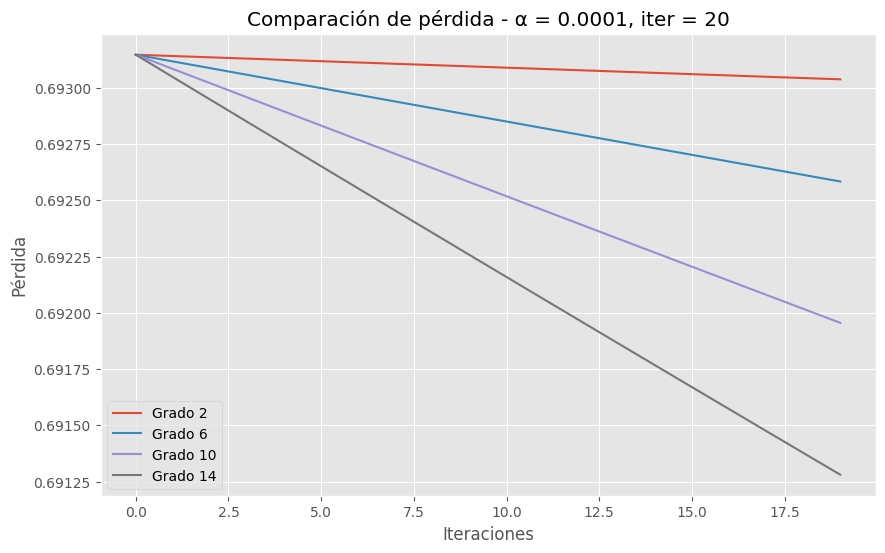

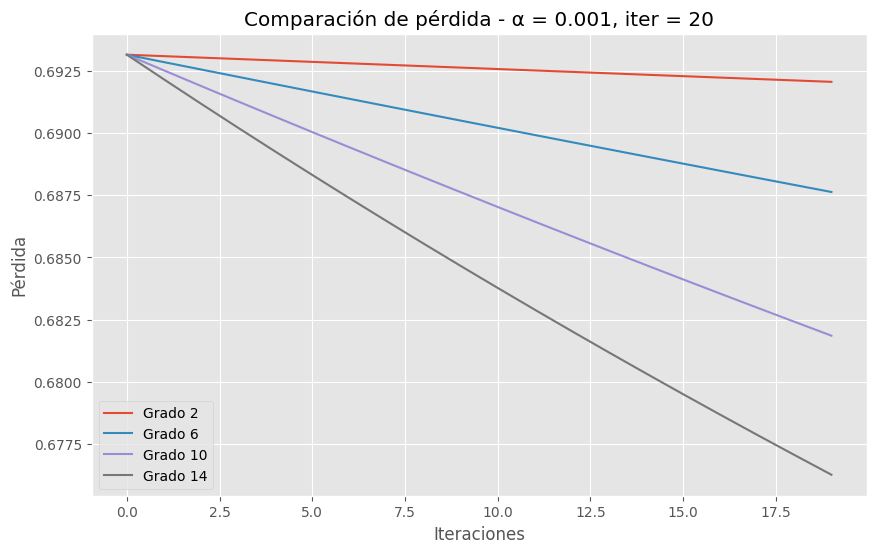

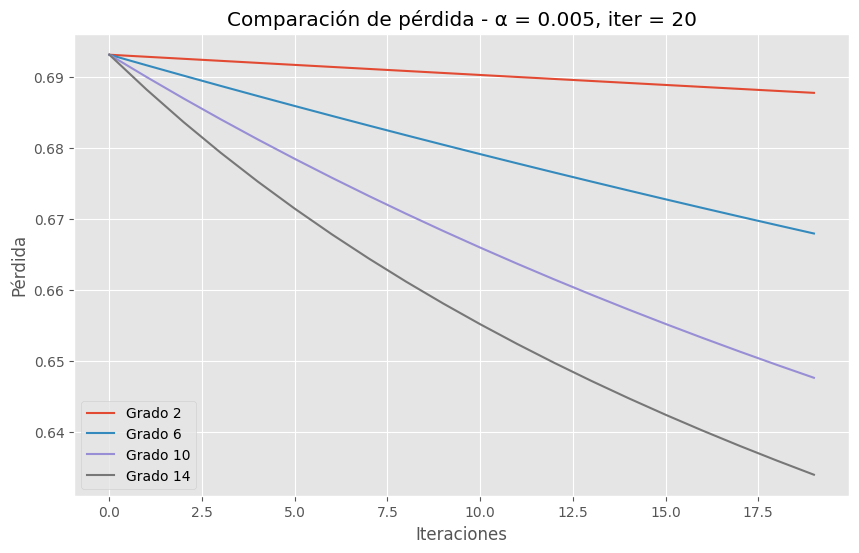

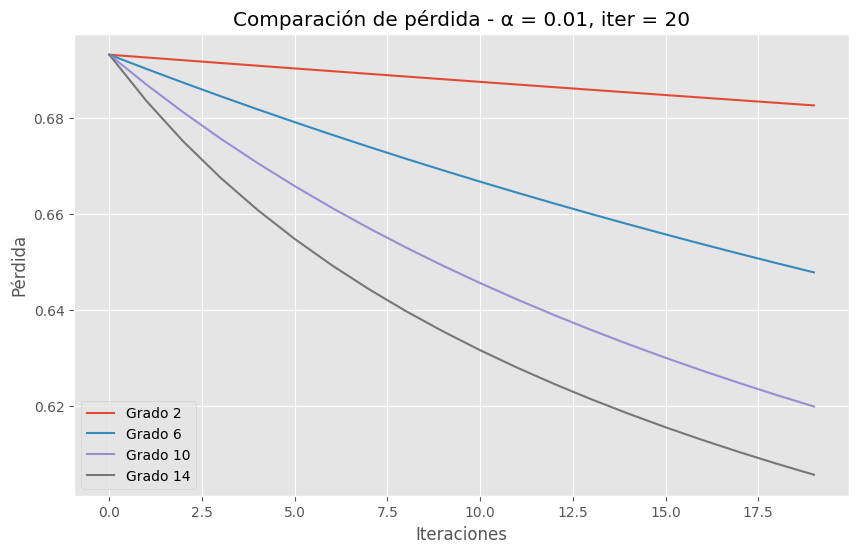

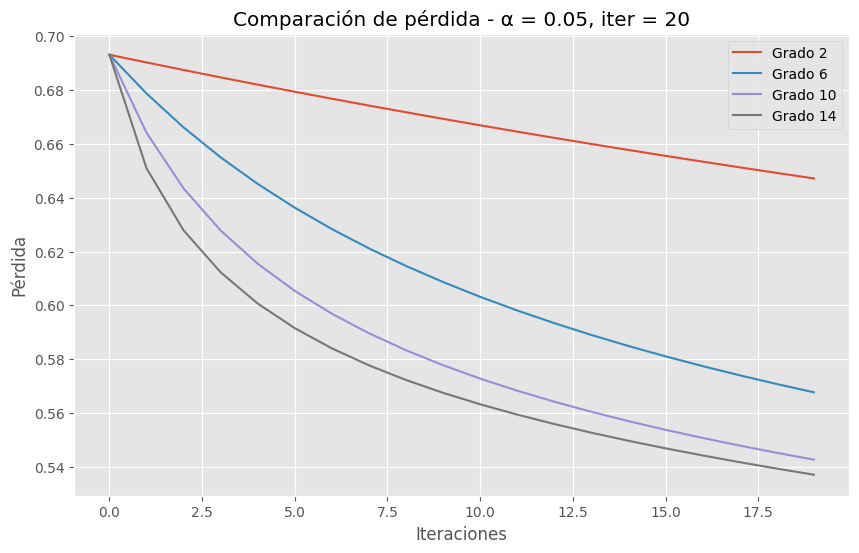

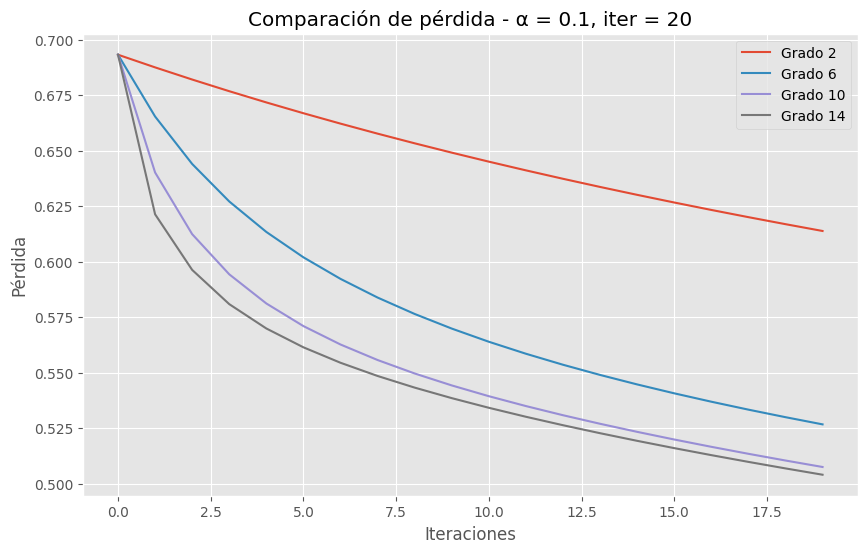

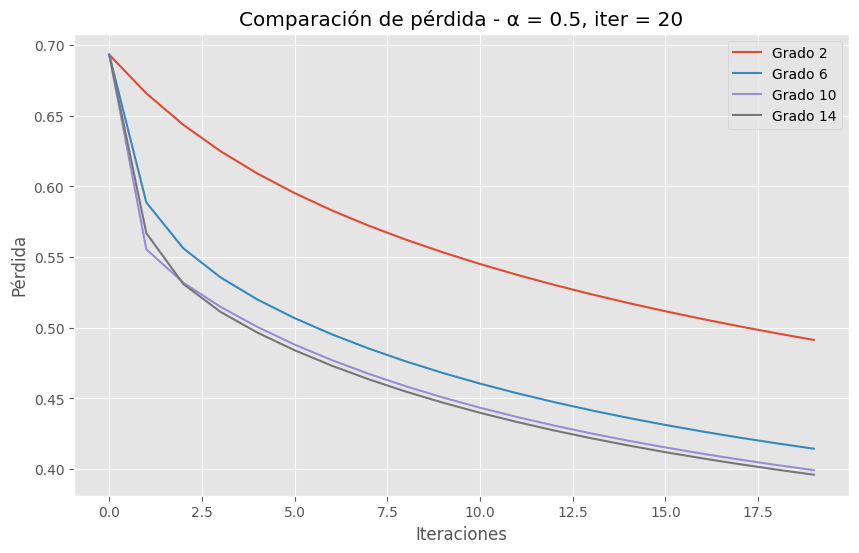

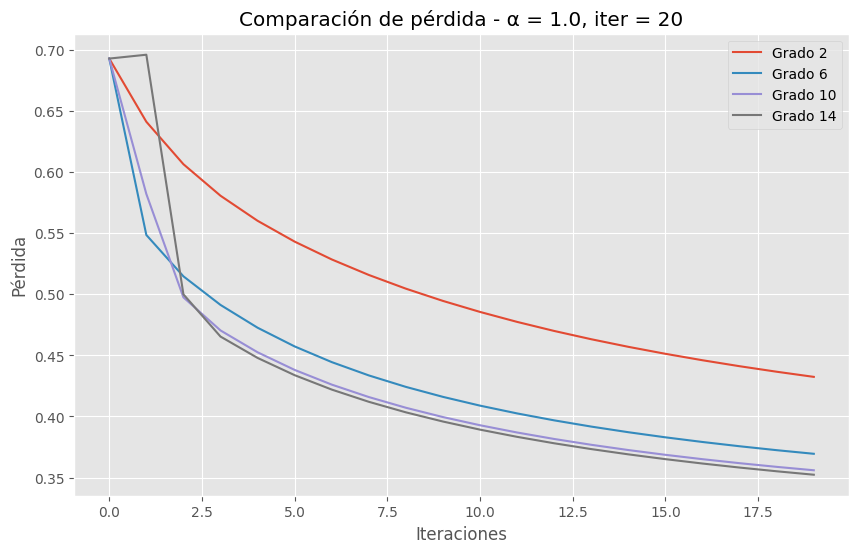

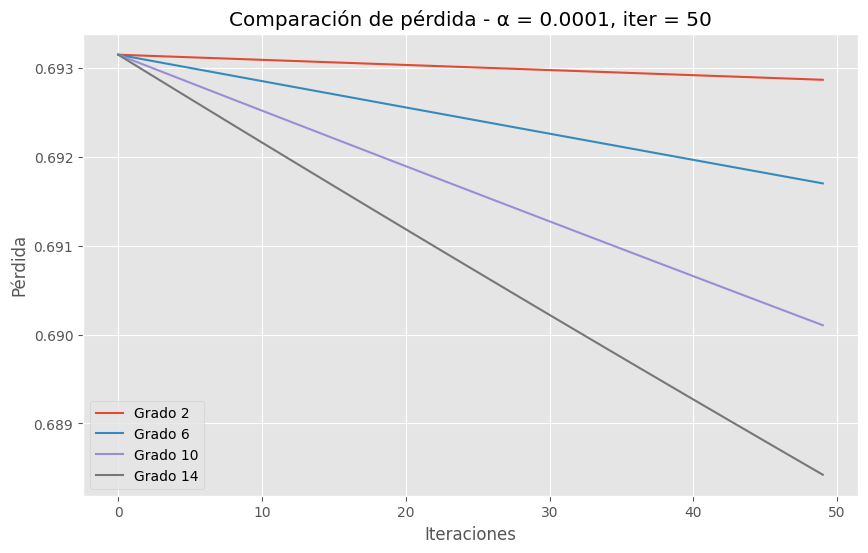

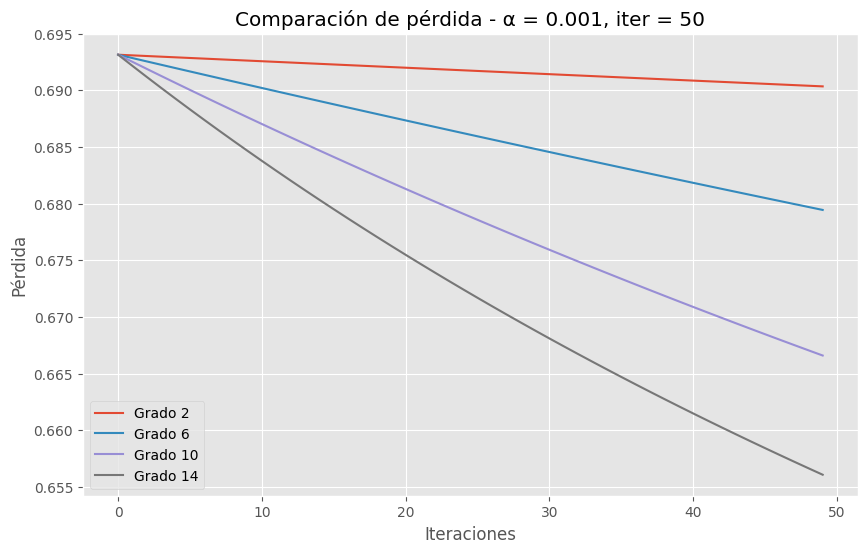

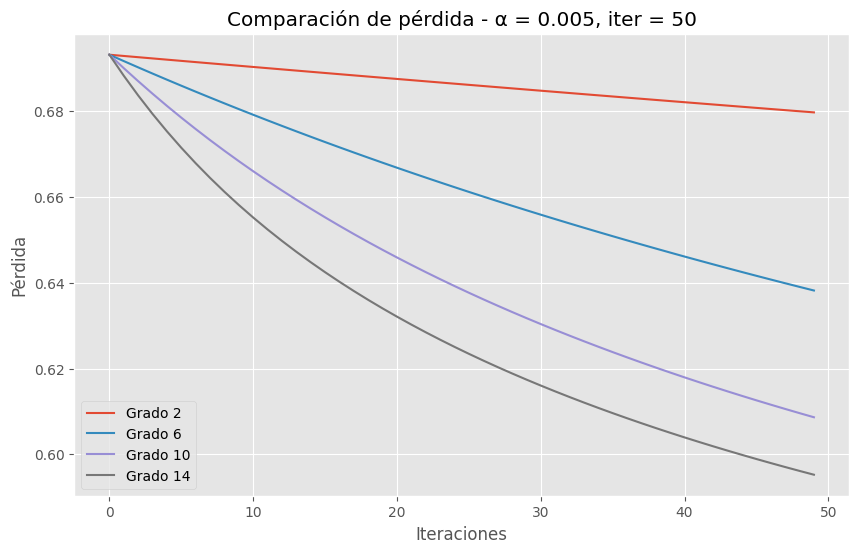

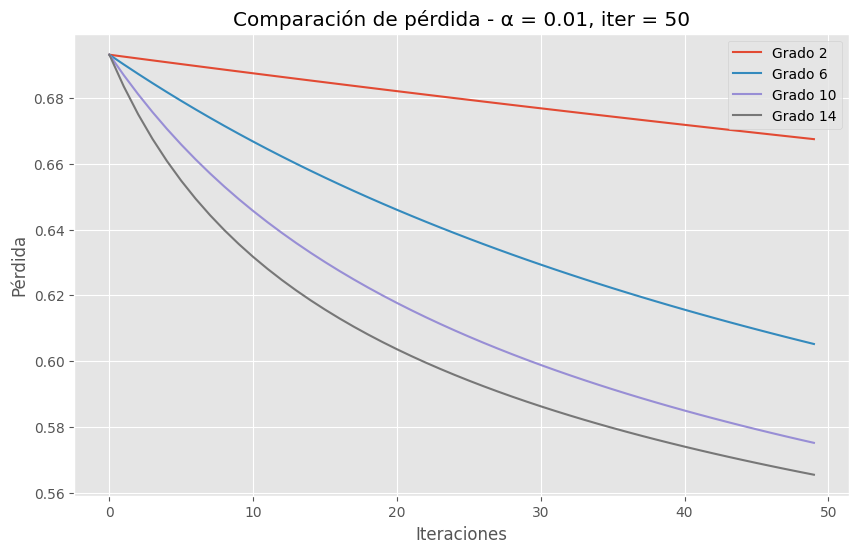

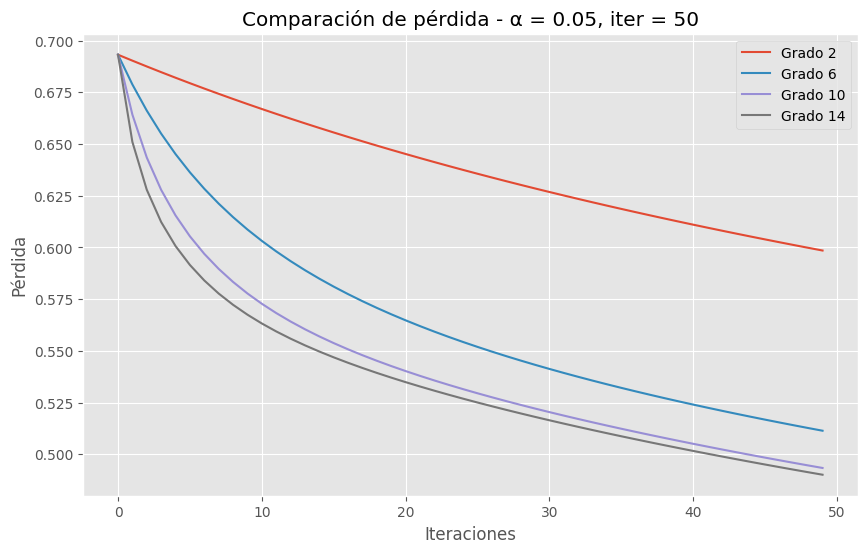

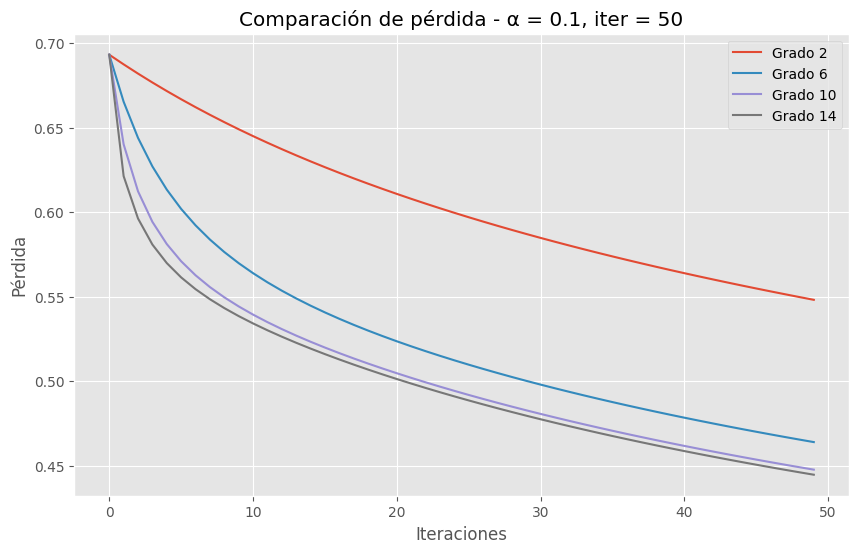

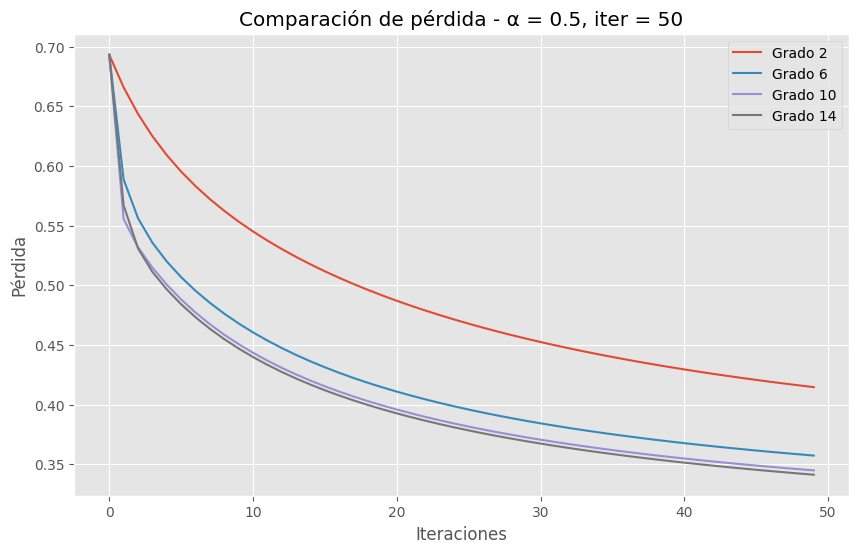

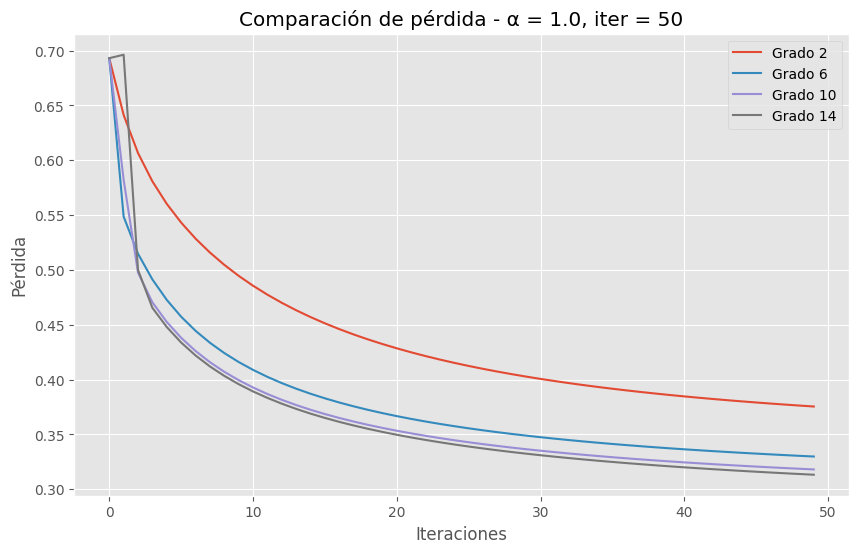

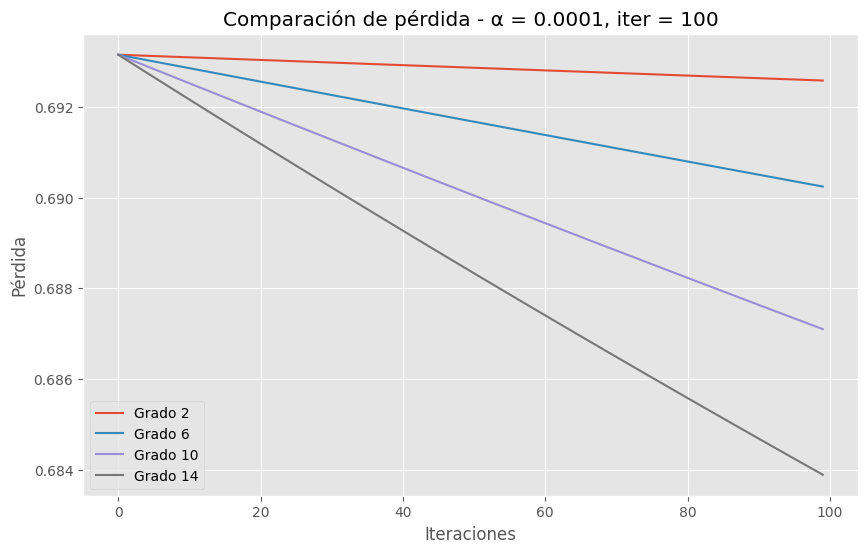

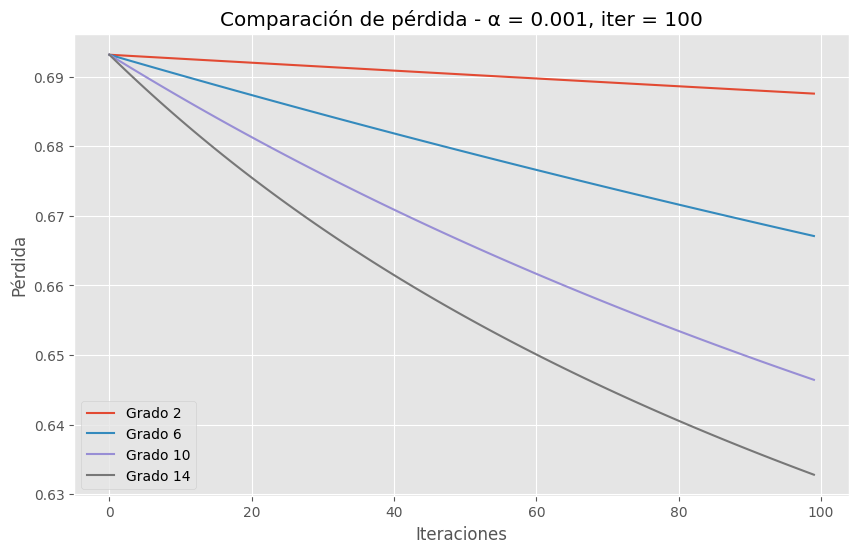

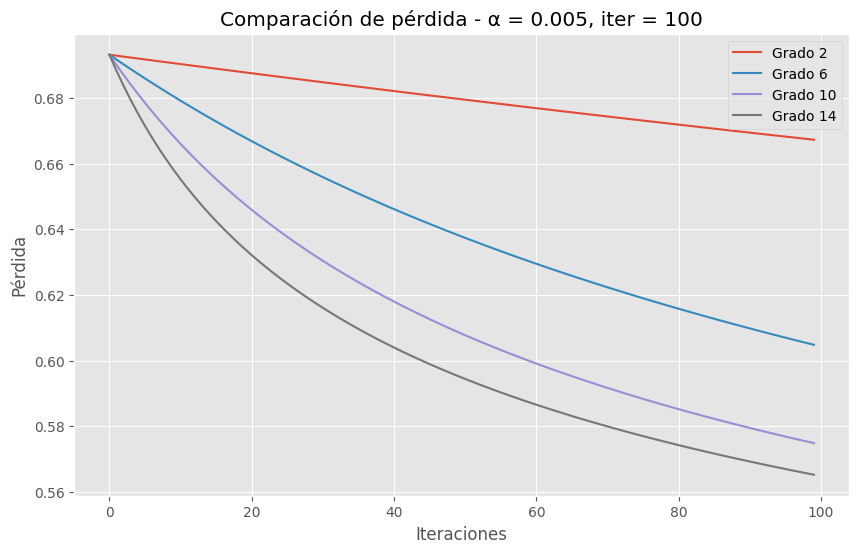

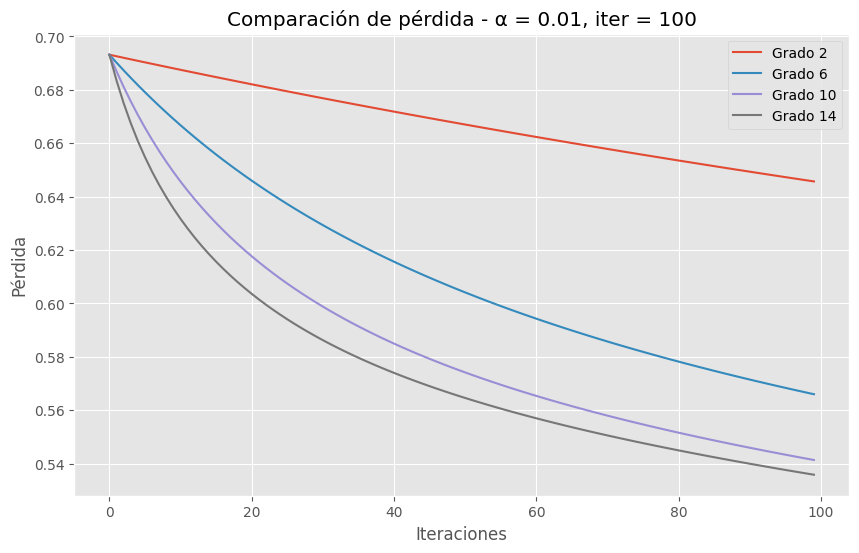

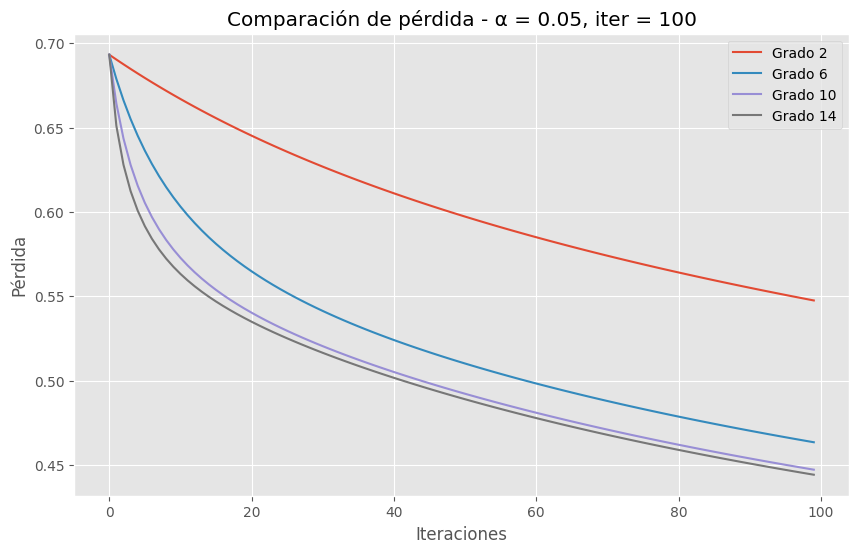

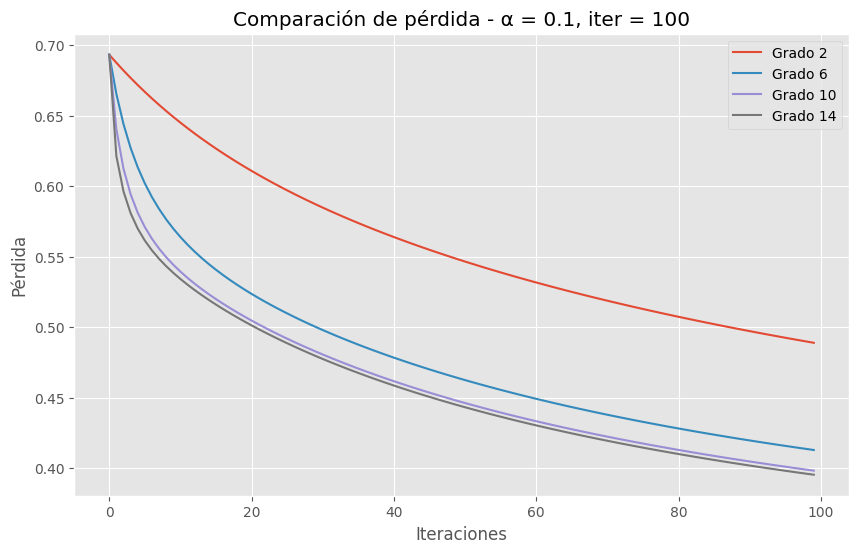

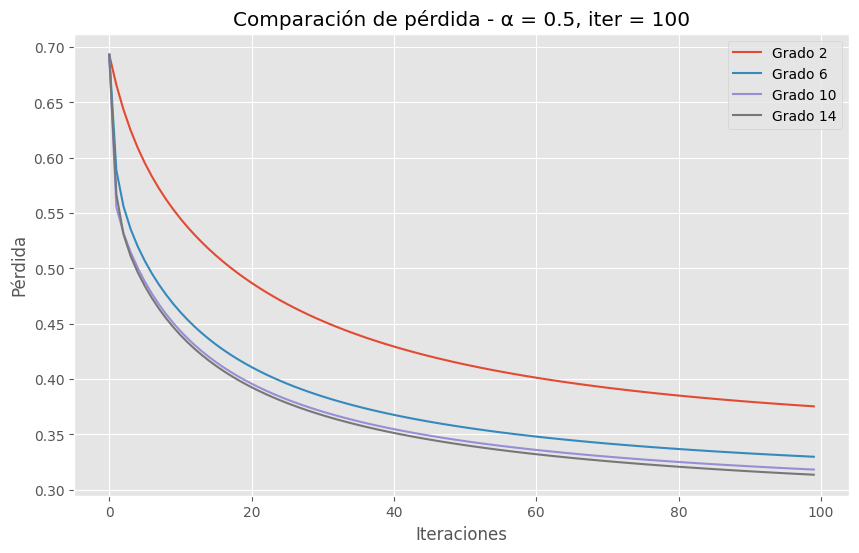

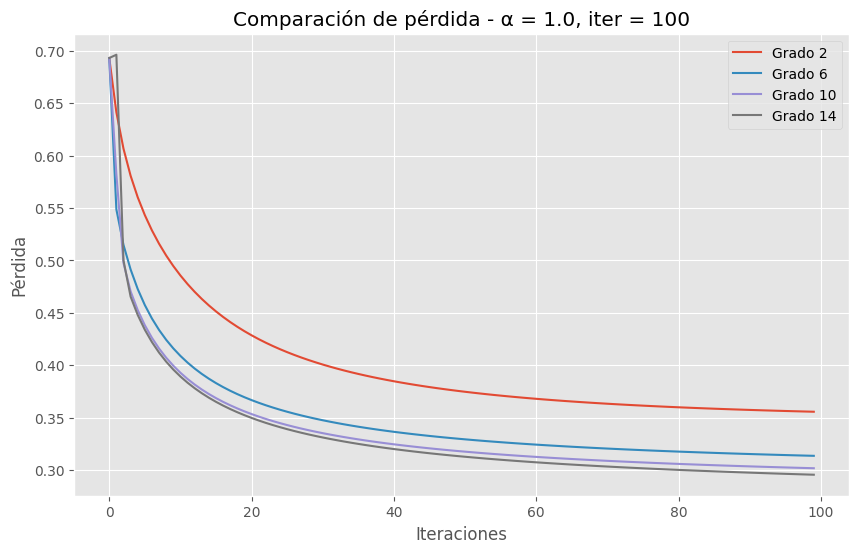

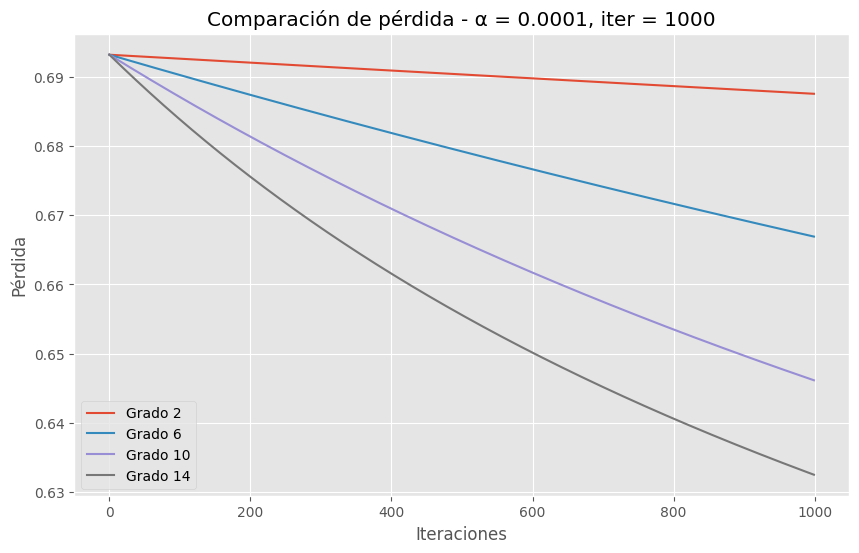

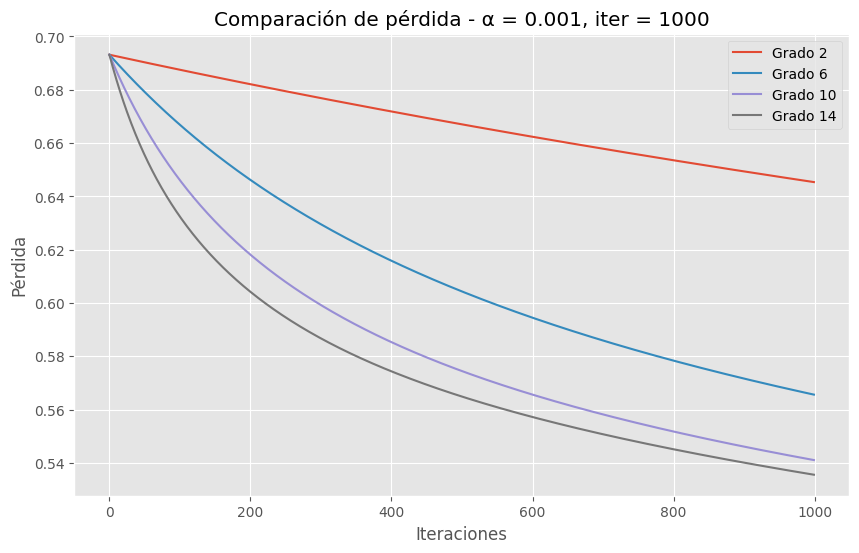

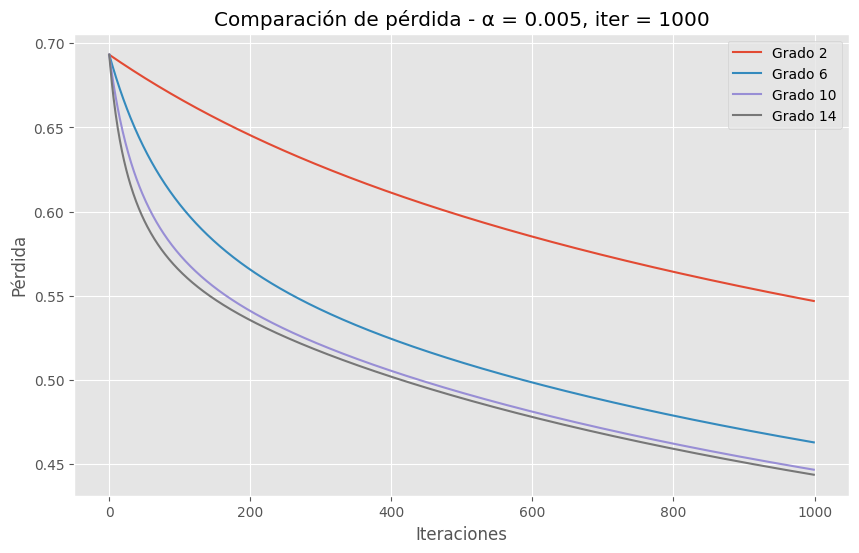

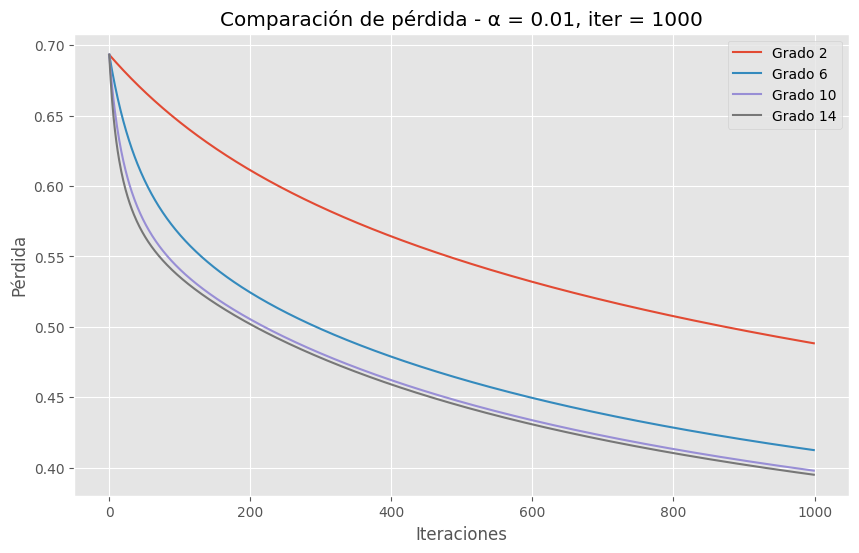

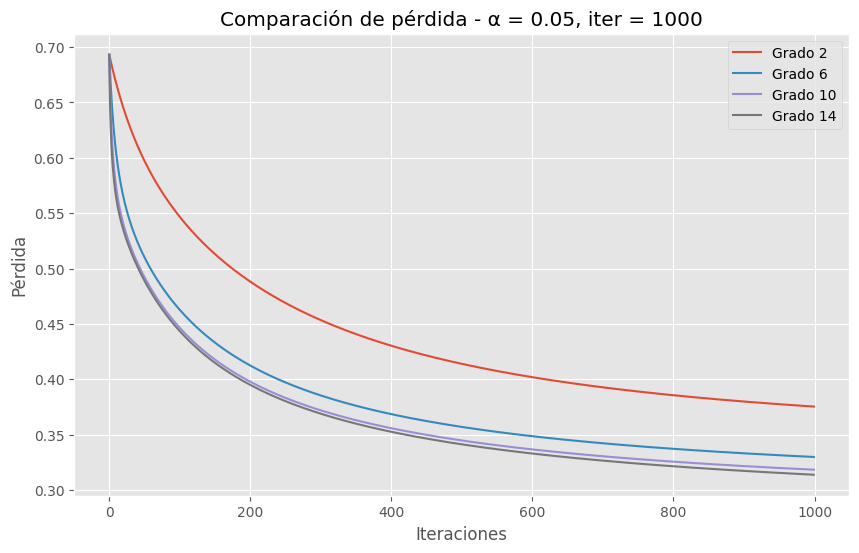

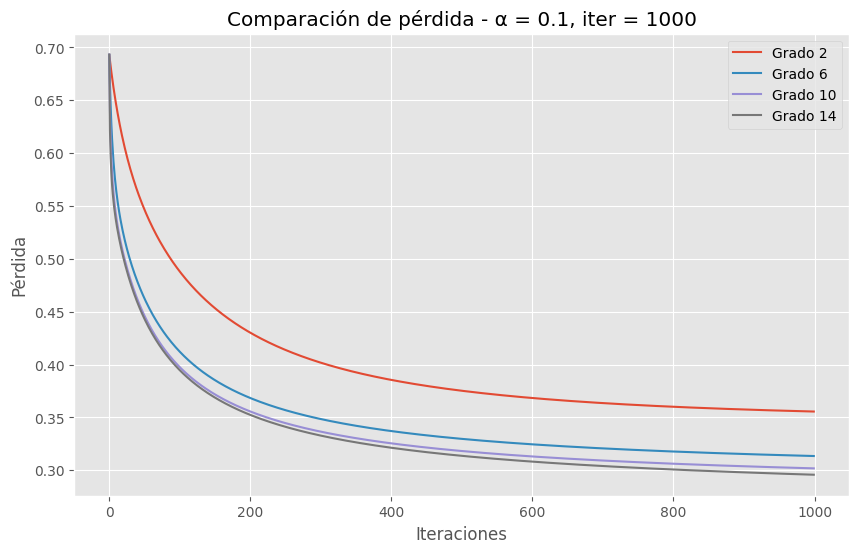

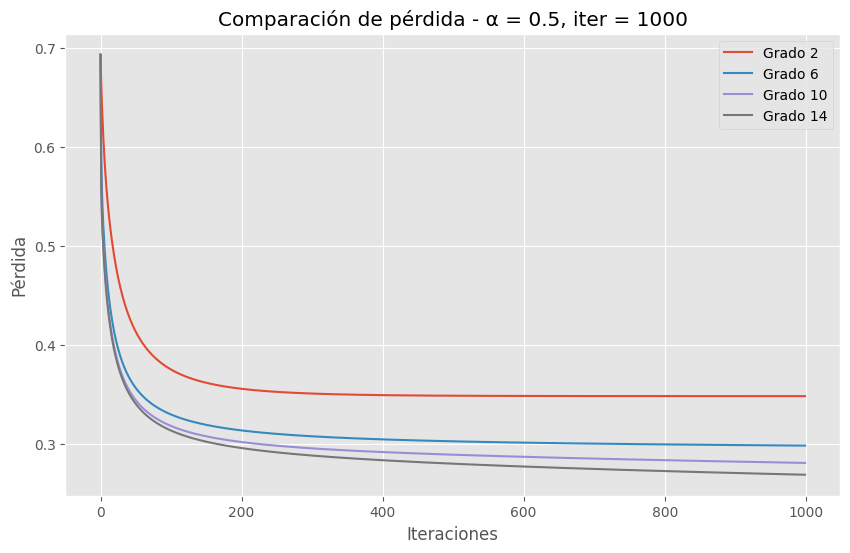

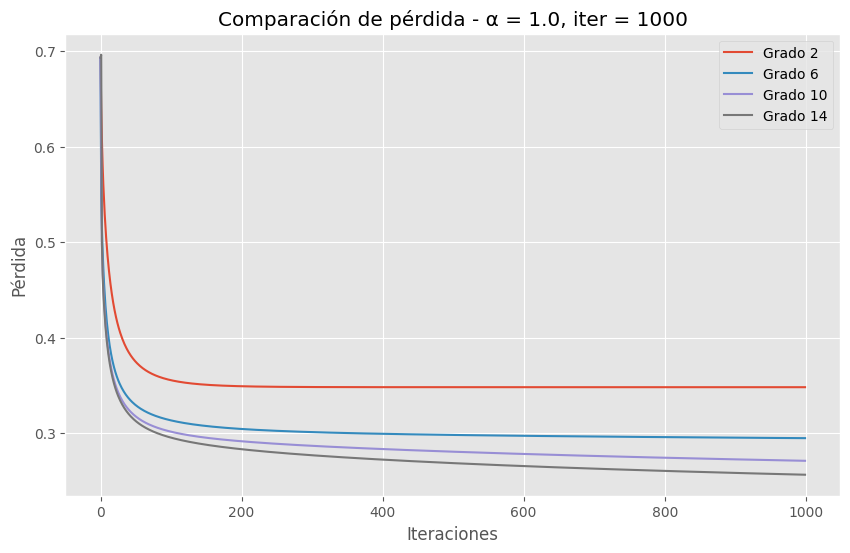

In [13]:
# Valores
alpha_values = [0.0001, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1.0]
max_iters = [20,50,100,1000]
grados = [2,6,10,14]

def entrenar_y_comparar(x, y, grados, alpha_values, max_iters):
    """
    Para cada iteración y alpha, genera una comparación de la pérdida para distintos grados.
    """
    for max_iter in max_iters:
        for alpha in alpha_values:
            plot_loss_comparativo(x, y, grados, alpha, max_iter)

entrenar_y_comparar(x, y, grados, alpha_values, max_iters)


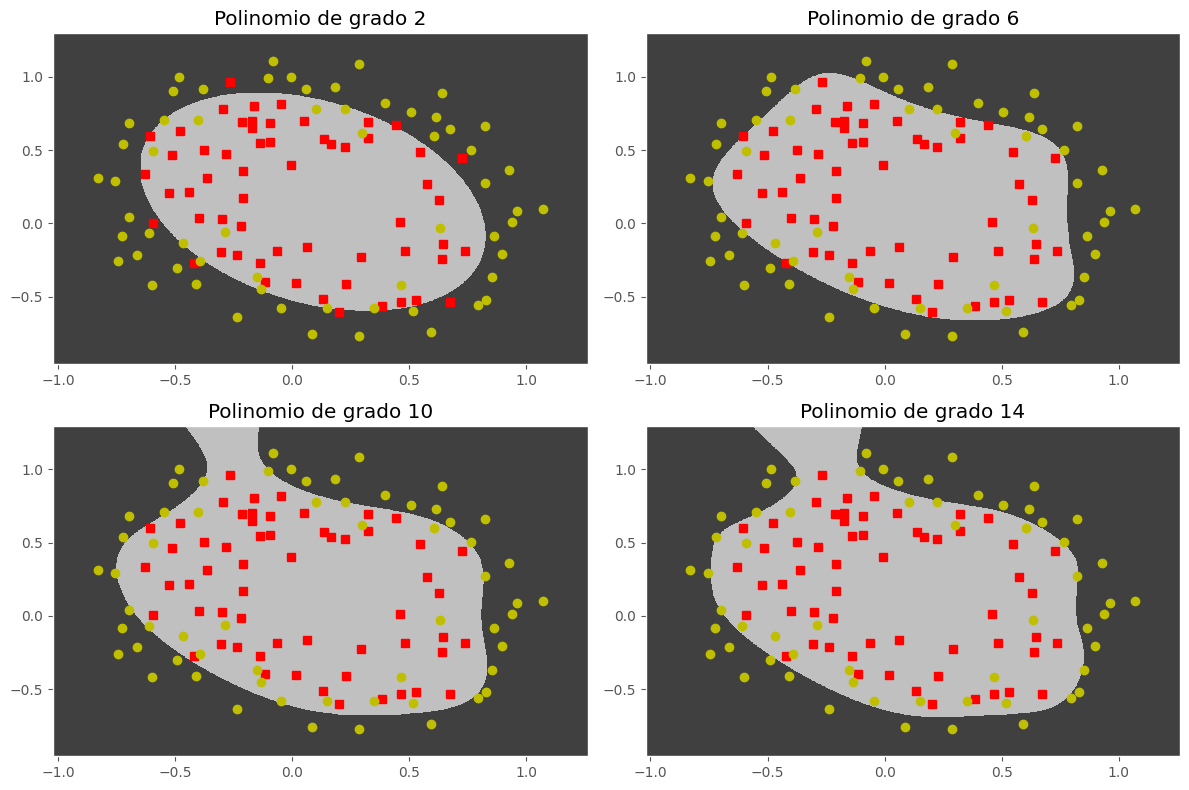

In [14]:
def entrenar_y_graficar_2D(x, y, grados):
    """
    Genera las fronteras de decisión para cada grado polinomial con alpha=0.5 y iter=1000
    """
    alpha = 0.5
    max_iter = 1000
    plt.figure(figsize=(12, 8))
    for i, grado in enumerate(grados):
        x_poly = map_poly(grado, x)
        mu, std = medias_std(x_poly)
        x_poly = normaliza(x_poly, mu, std)
        w = np.zeros(x_poly.shape[1])
        b = 0
        _, _, _ = dg(x_poly, y, w, b, alpha, max_iter, historial=False)
        plt.subplot(2, 2, i + 1)
        plot_separacion2D(x, y, grado, mu, std, w, b)
        plt.title(f"Polinomio de grado {grado}")
    plt.tight_layout()
    plt.show()

entrenar_y_graficar_2D(x, y, grados)

Como podemos ver del ejercicio anterior, es dificil determinar el grado del polinomio, y en algunos casos es demasiado general (subaprendizaje) y en otros demasiado específico (sobreaprendizaje).

¿Que podría ser la solución?, Una solución posible es utilizar un polinomio de alto grado (o relativamente alto), y utilizar la **regularización** para controlar la generalización del algoritmo, a través de una variable $\lambda$.

Recordemos, la función de costos de la regresión logística con regularización es:

$$
costo(w, b) = E_{in}(w, b) + \frac{\lambda}{M} regu(w),
$$

donde $regu(w)$ es una función de regularización, la cual puede ser $l_1$, $l_2$ u otras, tal como vimos en clase.

**Completa el siguiente código, utilizando una regularización en $L_2$**


In [15]:
def costo(x, y, w, b, lambd):
    """
    Calcula el costo de una w dada para el conjunto dee entrenamiento dado por y y x,
    usando regularización

    @param x: un ndarray de dimensión (M, n) con la matriz de diseño
    @param y: un ndarray de dimensión (M, ) donde cada entrada es 1.0 o 0.0
    @param w: un ndarray de dimensión (n, ) con los pesos
    @param b: un flotante con el sesgo
    @param lambd: un flotante con el valor de lambda en la regularizacion

    @return: un flotante con el valor de pérdida

    """
    M = x.shape[0]

    regularizacion = (lambd / (2 * M)) * np.sum(w ** 2)

    costo = error_in(x, y, w, b) + regularizacion
    return costo


def grad_regu(x, y, w, b, lambd):
    """
    Calcula el gradiente de la función de costo regularizado para clasificación binaria,
    utilizando una neurona logística, para w y b y conociendo un conjunto de aprendizaje.

    @param x: un ndarray de dimensión (M, n) con la matriz de diseño
    @param y: un ndarray de dimensión (M, ) donde cada entrada es 1.0 o 0.0
    @param w: un ndarray de dimensión (n, ) con los pesos
    @param b: un flotante con el sesgo
    @param lambd: un flotante con el peso de la regularización

    @return: dw, db, un ndarray de mismas dimensiones que w y un flotnte con el cálculo de
             la dervada evluada en el punto w y b

    """
    M = x.shape[0]
    dw = np.zeros_like(w)
    db = 0.0

    a = logistica(x @ w + b)
    error = a - y
    dw = (x.T @ error) / M + (lambd / M) * w # Grad con reg L2
    db = np.mean(error)  # Grad del sesgo
    return dw, db


def dg_regu(x, y, w, b, alpha, lambd, max_iter=10_000, tol=1e-4, historial=False):
    """
    Descenso de gradiente con regularización l2

    @param x: un ndarray de dimensión (M, n) con la matriz de diseño
    @param y: un ndarray de dimensión (M, ) donde cada entrada es 1.0 o 0.0
    @param alpha: Un flotante (típicamente pequeño) con la tasa de aprendizaje
    @param lambd: Un flotante con el valor de la regularización
    @param max_iter: Máximo numero de iteraciones. Por default 10_000
    @param tol: Un flotante pequeño como criterio de paro. Por default 1e-4
    @param historial: Un booleano para saber si guardamos el historial

    @return:
        - w: ndarray de dimensión (n, ) con los pesos;
        - b:  float con el sesgo
        - hist: ndarray de (max_iter,) el historial de error.
                Si historial == False, entonces hist = None.

    """
    M, n = x.shape
    hist = [costo(x, y, w, b, lambd)] if historial else None
    for epoch in range(1, max_iter):
        dw, db = grad_regu(x, y, w, b, lambd)
        w -= alpha * dw
        b -= alpha * db
        error = costo(x, y, w, b, lambd)
        if historial:
            hist.append(error)
        if np.abs(np.max(dw)) < tol:
            break
    return w, b, hist



**Desarrolla las funciones y scripts necesarios para realizar la regresión logística con un polinomio de grado `grado` y con cuatro valores de regularización diferentes. Grafica la superficie de separación para cuatro valores diferentes de $\lambda$.**

Realiza varias pruebas para encontrar cual es la relación de `grado` y de $\lambda$ que sea un buen compromiso entre generalizar demasiado o tener sobreaprendizaje.

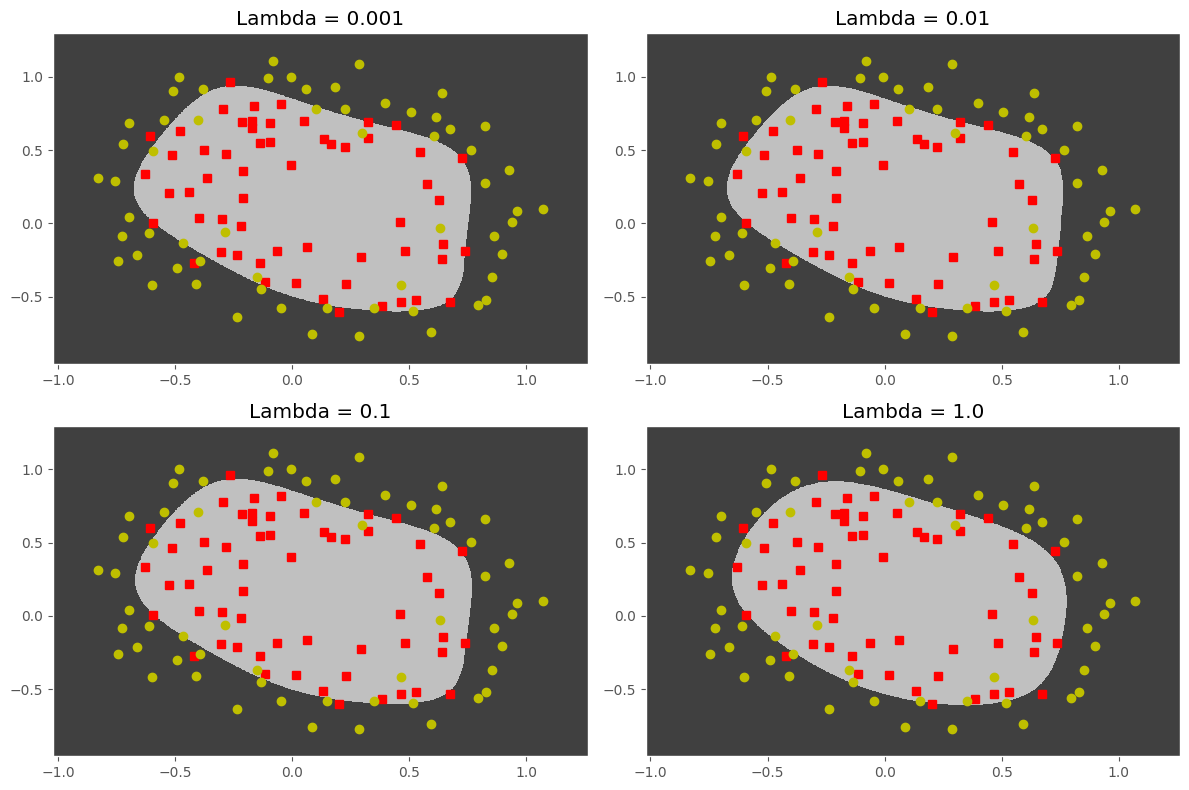

In [16]:
def entrenar_y_graficar_regu(x, y, grado, lambdas, alpha=0.5, max_iter=1000):
    """
    Entrena el modelo con diferentes valores de lambda y grafica los resultados.
    """
    # Normaliza
    phi_x = map_poly(grado, x)
    mu, de = medias_std(phi_x)
    phi_x_norm = normaliza(phi_x, mu, de)

    plt.figure(figsize=(12, 8))
    for i, lambd in enumerate(lambdas):
        w = np.zeros(phi_x_norm.shape[1])
        b = 0
        # Entrena
        w, b, _ = dg_regu(phi_x_norm, y, w, b, alpha, lambd, max_iter)
        plt.subplot(2, 2, i + 1)
        # Muestra resultados con plot_separacion2D
        plot_separacion2D(x, y, grado, mu, de, w, b)
        plt.title(f"Lambda = {lambd}")
    plt.tight_layout()
    plt.show()



grado = 5

lambdas = [0.001, 0.01, 0.1, 1.0]
entrenar_y_graficar_regu(x, y, grado, lambdas)

Es muy importante el análisis y las conclusiones que puedas sacar de este ejercicio.

**Escribe aquí tus conclusiones**

### Conclusiones

Con pocas iteraciones puede que el modelo no converja.

Tambien, para $\alpha$ demasiado grande puede hacer que el descenso de gradiente no converja y un $\alpha$ muy pequeño hace que el aprendizaje sea lento. En este caso, $\alpha= 0.5$ parece ser un buen candidato que ofrece velocidad y estabilidad.

En cuanto a los grados:Grados bajo generan fronteras de tipo elipse que pueden no capturar bien la estructura de los datos; Grados altos sin regularización generan sobreajuste, adaptándose demasiado a los puntos de entrenamiento.

Sin regularizacion, el modelo tiende a sobreajustarse, especialmente para grados altos. Si usamos la regularización L2, se suaviza y no aparecen cosas extranias. Ademas, para valores de $\lambda$ muy bajos no afectan mucho la solución, mientras que valores muy altos vuelven a generar un subajuste.





